In [1]:
import sys
import numpy as np
import pylab as pl

import pycbc.waveform
from pycbc.detector import Detector
from pycbc import frame

## Parameters to create a GW waveform

In [40]:
mass1 = 1.8
mass2 = 1.6
spin1x = 0.0
spin1y = 0.0
spin1z = 0.1
spin2x = 0.0
spin2y = 0.0
spin2z = 0.2
ra = 2.1
dec = 1.5
distance = 0.1 # Close distance so that the injection can be seen in the data
inclination = 0.2
polarization = 0.3
lambda1 = 0.0
lambda2 = 0.0
coa_phase = 1.1
f_lower = 15
f_ref = 0
approximant = 'IMRPhenomPv2_NRTidalv2'
t = 1264069376

## Create a GW waveform

In [41]:
hp, hc = pycbc.waveform.get_td_waveform(approximant='IMRPhenomPv2_NRTidalv2', mass1=mass1,
                                        mass2=mass2, lambda1=lambda1, lambda2=lambda2,
                                        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                                        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,
                                        distance=distance, inclination=inclination,
                                        coa_phase=coa_phase, f_lower=f_lower, f_ref=f_ref,
                                        polarization=polarization, delta_t=1/16384)

## Project the wave into a detector

In [42]:
d = Detector("L1")
hp.start_time = hc.start_time = t - (hp.end_time - hp.start_time)
h = d.project_wave(hp, hc, ra, dec, polarization)

## Plot the projected waveform

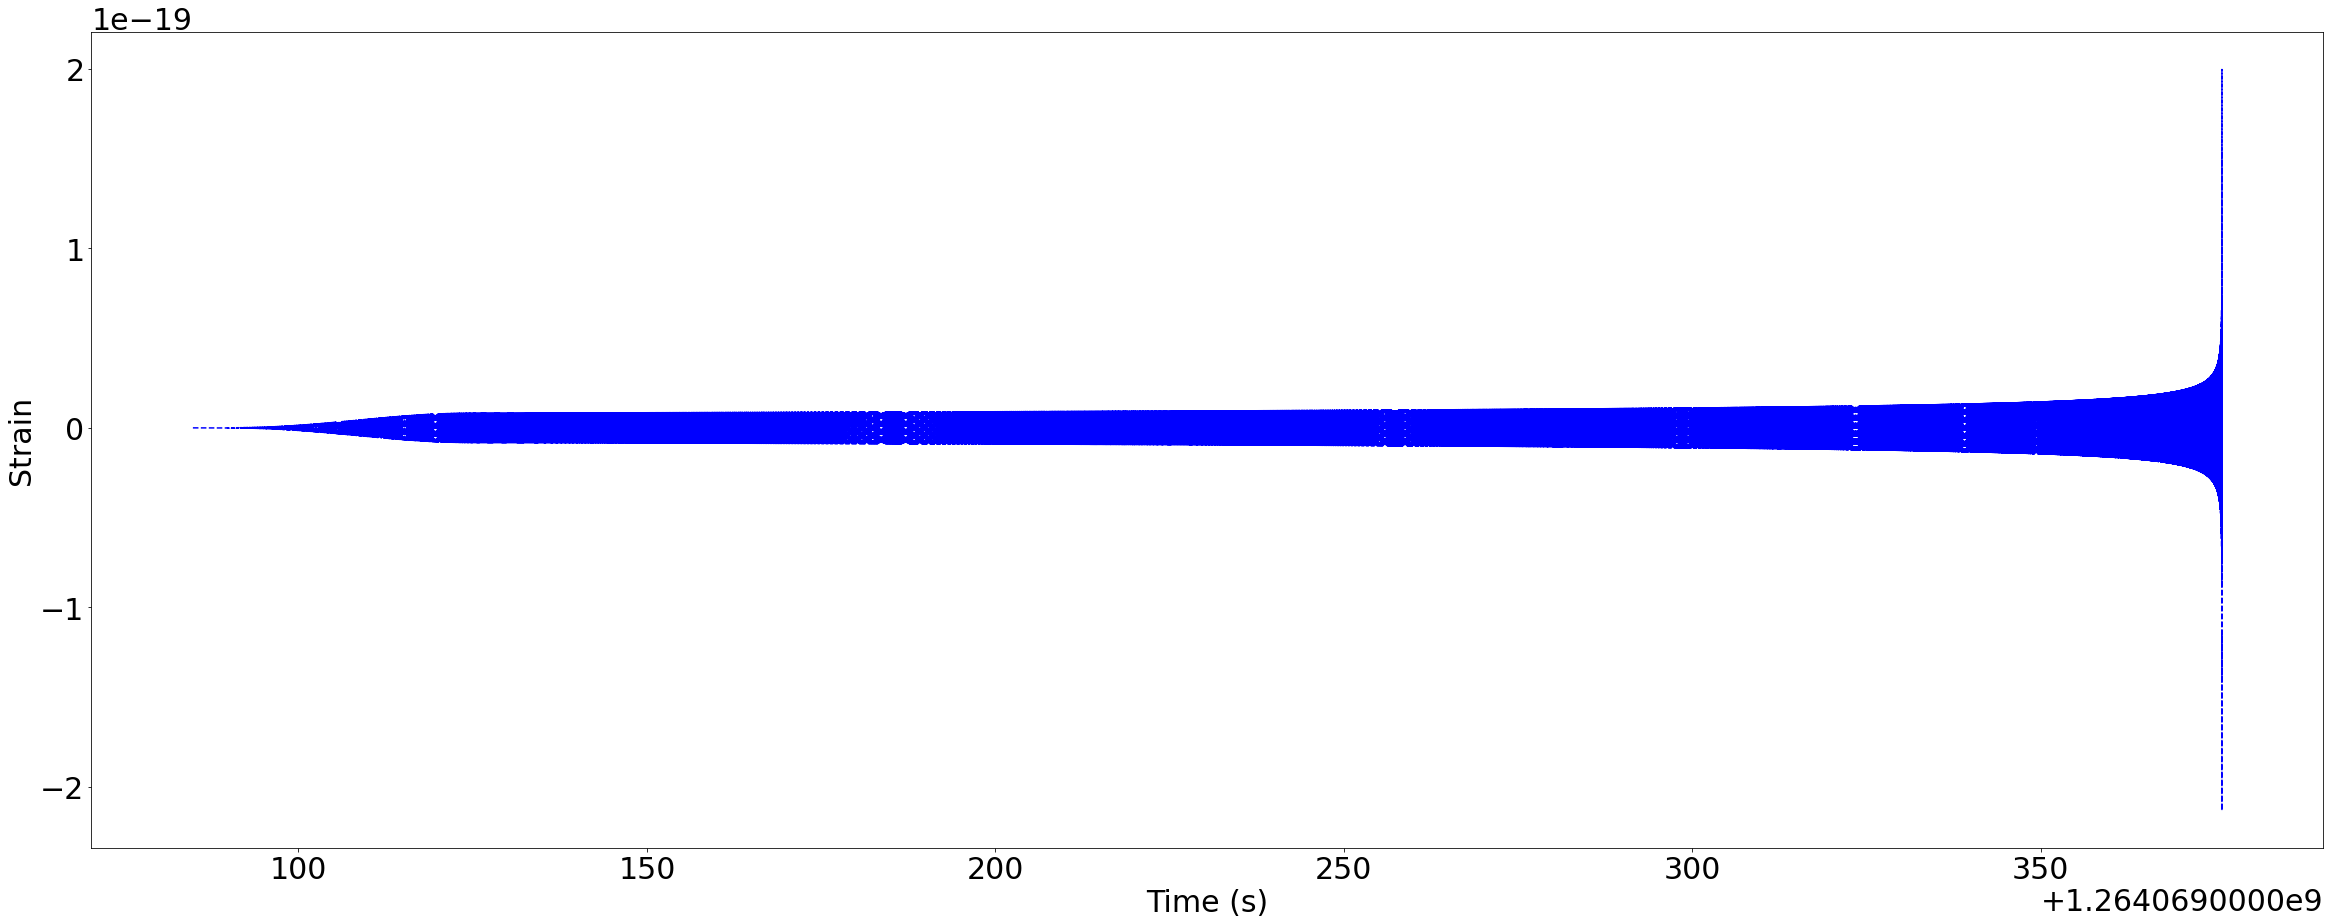

In [43]:
pl.rcParams.update({'font.size': 30})
pl.figure(figsize=(40,15))

pl.plot(h.sample_times.data, h.data, 'b--')
pl.xlabel('Time (s)')
pl.ylabel('Strain')
pl.show()

## Create an injection file with the given parameters

In [44]:
from pycbc.io import FieldArray
from pycbc.inject import InjectionSet

In [45]:
dtype = [('mass1', float), ('mass2', float),
         ('spin1x', float), ('spin2x', float),
         ('spin1y', float), ('spin2y', float),
         ('spin1z', float), ('spin2z', float),
         ('tc', float), ('distance', float),
         ('ra', float), ('dec', float),
         ('approximant', 'S32'), ('f_lower', float),
         ('f_ref', float), ('inclination', float),
         ('coa_phase', float), ('polarization', float),
         ('lambda1', float), ('lambda2', float)]

In [46]:
static_params = {'taper': 'start',
                 'eccentricity': 0.
                 }

In [47]:
num_inj = 1
samples = FieldArray(num_inj, dtype=dtype)

In [48]:
samples['mass1'] = mass1
samples['mass2'] = mass2
samples['spin1x'] = spin1x
samples['spin2x'] = spin2x
samples['spin1y'] = spin1y
samples['spin2y'] = spin2y
samples['spin1z'] = spin1z
samples['spin2z'] = spin2z
samples['tc'] = t
samples['ra'] = ra
samples['dec'] = dec
samples['distance'] = distance
samples['inclination'] = inclination
samples['polarization'] = polarization
samples['f_ref'] = f_ref
samples['f_lower'] = f_lower
samples['coa_phase'] = coa_phase
samples['lambda1'] = 0
samples['lambda2'] = 0
samples['approximant'] = approximant

In [49]:
InjectionSet.write('injection_10Mpc.hdf5', samples,
                   static_args=static_params, injtype='cbc',
                   cmd=" ".join(sys.argv))

In [50]:
# Some quick calculations
h.end_time - h.start_time # What is the duration of the signal
frame_start_time = t - 512
frame_end_time = t + 512

## Read the frame file with the injection

In [51]:
frame_data = frame.read_frame('L-L1_STRAIN-1264068864-1024.gwf', 'L1:SIM-STRAIN')

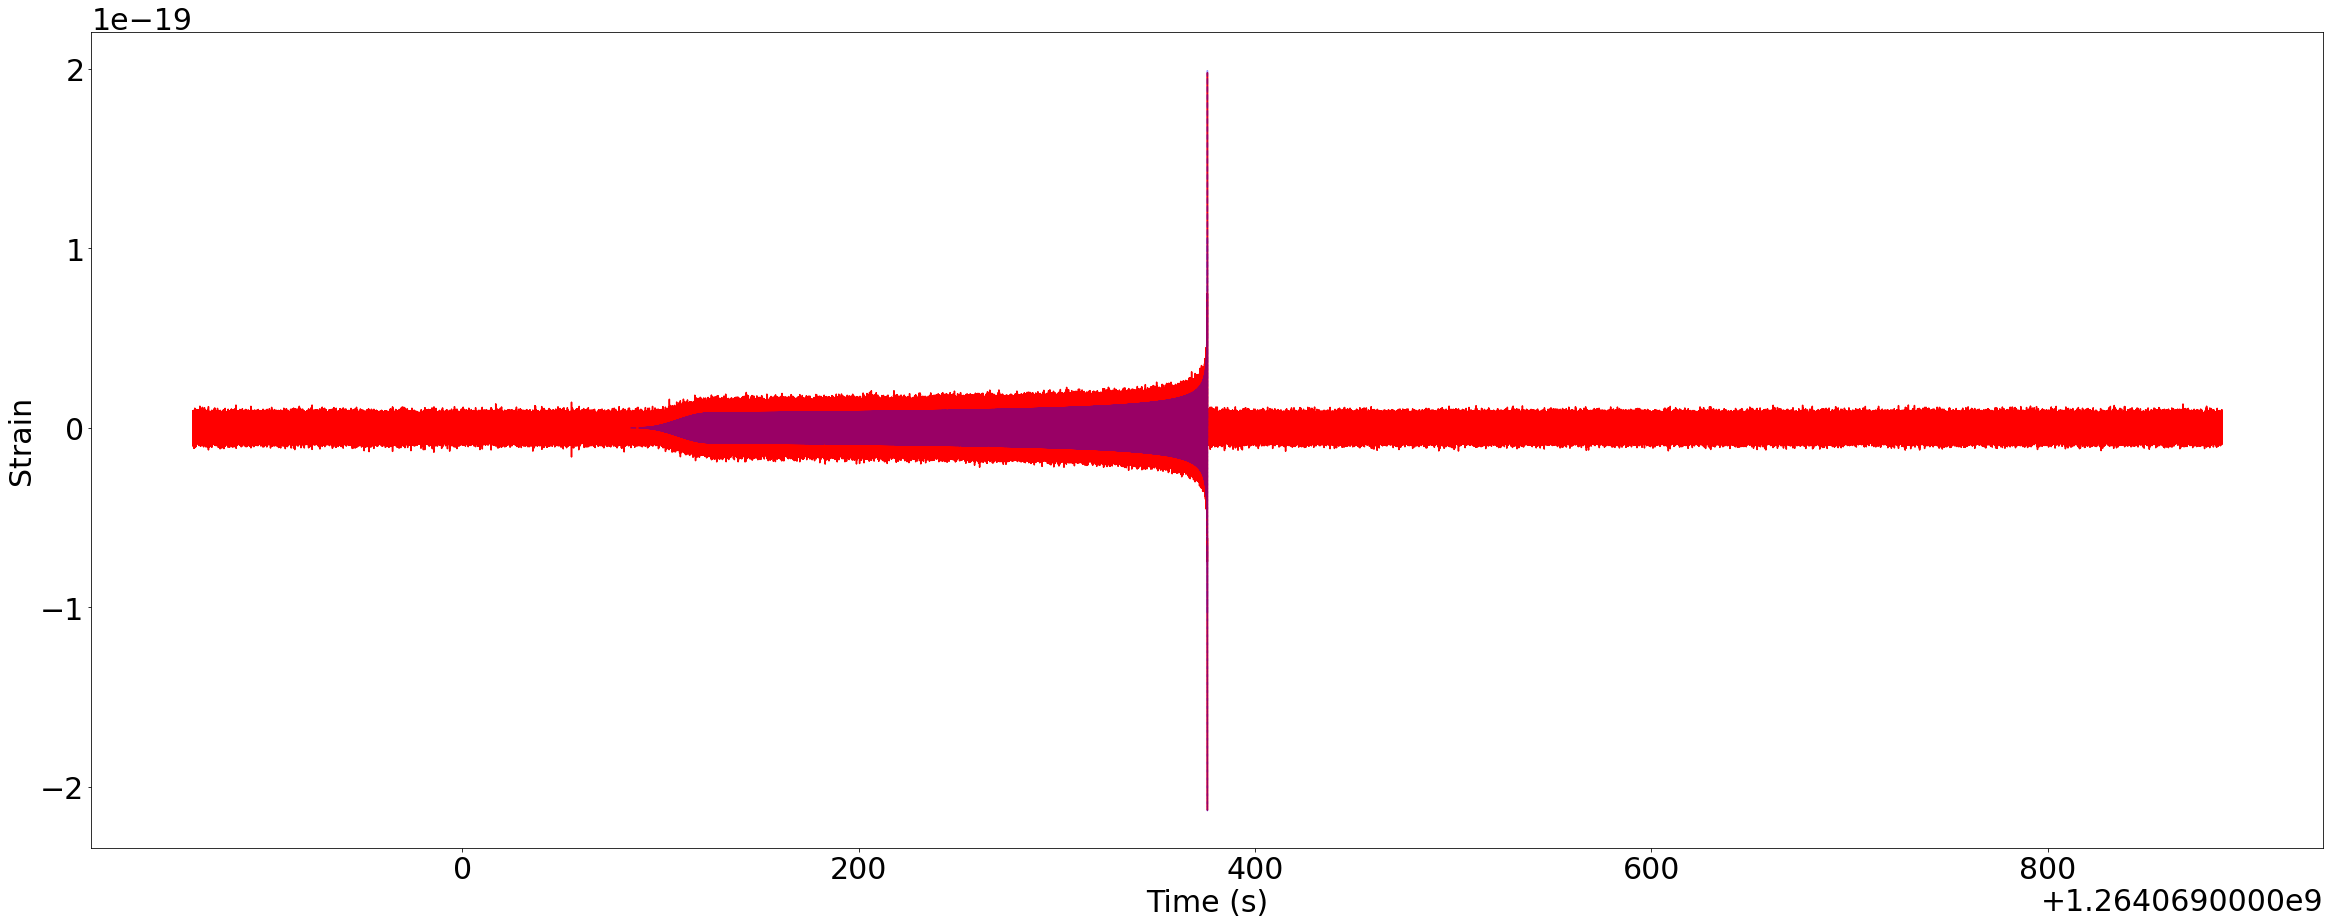

In [52]:
pl.rcParams.update({'font.size': 30})
pl.figure(figsize=(40,15))
pl.plot(frame_data.sample_times.data, frame_data.data, 'r-')
pl.plot(h.sample_times.data, h.data, 'b--', alpha=0.4)
pl.xlabel('Time (s)')
pl.ylabel('Strain')
pl.show()

`pycbc_condition_strain --injection-file injection_10Mpc.hdf5 --channel-name L1:SIM-STRAIN --output-strain-file L-L1_STRAIN-{start}-{duration}.gwf --fake-strain-from-file ~/git_repositories/other_repos/O4_studies/pycbc_products/aligo_O4high_extrapolated.txt --fake-strain-seed 100 --low-frequency-cutoff 15 --fake-strain-flow 15 --frame-duration 1024 --gps-start-time 1264068864 --gps-end-time 1264069888 --sample-rate 16384`

## Antenna pattern function

```
d = Detector("L1")
fp, fc = d.antenna_pattern(ra, dec, polarization, t)
```
$F_{+}$ and $F_{\times}$ are the antenna patterns that are used to computed the detector response. Write a script to compute the antenna pattern function over a grid on the sky, and find how $\sqrt{F_{+}^2 + F_{\times}^2}$ evolves across the sky.